In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import json
import warnings
warnings.filterwarnings('ignore')

print("Iniciando carga y preprocesamiento de datos...\n")

try:
    df = pd.read_json('cadiz_final.json', encoding='utf-8')
    print(f"Archivo 'cadiz_final.json' cargado exitosamente.")
    print(f"Formato detectado: {type(df)}")
except ValueError as e:
    print("Formato JSON no estándar. Intentando lectura alternativa...")
    with open('cadiz_final.json', 'r', encoding='utf-8') as f:
        data = json.load(f)
        if isinstance(data, list):
            df = pd.DataFrame(data)
            print("JSON convertido a DataFrame desde lista de registros.")
        else:
            df = pd.json_normalize(data)
            print("JSON anidado normalizado a DataFrame plano.")

columnas_esperadas = ['fecha', 'indicativo', 'nombre', 'provincia', 'altitud', 
                      'tmed', 'prec', 'tmin', 'tmax', 'dir', 'velmedia', 
                      'racha', 'hrMedia', 'hrMax', 'hrMin']

faltantes = [col for col in columnas_esperadas if col not in df.columns]
if faltantes:
    print(f"Columnas faltantes: {faltantes}")
    print("   Columnas disponibles:", list(df.columns))
    raise ValueError("El archivo no contiene todas las columnas esperadas.")
else:
    print(f"Todas las columnas requeridas presentes ({len(df)} registros).")

df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df = df.dropna(subset=['fecha'])  

df['mes'] = df['fecha'].dt.month
df['dia_anio'] = df['fecha'].dt.dayofyear
df['dia_semana'] = df['fecha'].dt.dayofweek

df = df.drop(columns=['fecha', 'indicativo', 'nombre', 'tmin', 'tmax'])

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

imputer_num = SimpleImputer(strategy='median')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

if 'provincia' in cat_cols:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df[['provincia']] = imputer_cat.fit_transform(df[['provincia']])
    df = pd.get_dummies(df, columns=['provincia'], drop_first=True)
    print(f"Provincia codificada con one-hot encoding.")

y = df['tmed']
X = df.drop(columns=['tmed'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print(f"\n División de datos:")
print(f"   • Entrenamiento: {len(X_train)} muestras ({len(X_train)/len(df)*100:.1f}%)")
print(f"   • Prueba:        {len(X_test)} muestras ({len(X_test)/len(df)*100:.1f}%)")

print("\n Entrenando modelo Random Forest...")
modelo = RandomForestRegressor(
    n_estimators=100,
    max_depth=25,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

print(f"\n Métricas del modelo en conjunto de prueba:")
print(f"   • R²:  {r2:.4f}")
print(f"   • RMSE: {rmse:.2f} °C")
print(f"   • MAE:  {mae:.2f} °C")

import pickle
with open('modelo_temp_cadiz.pkl', 'wb') as f:
    pickle.dump({
        'modelo': modelo,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred': y_pred,
        'columnas': X.columns.tolist()
    }, f)

print("\n Modelo y datos guardados en 'modelo_temp_cadiz.pkl'")
print("\n Ejecuta ahora el código de visualización para ver las gráficas")

Iniciando carga y preprocesamiento de datos...

Archivo 'cadiz_final.json' cargado exitosamente.
Formato detectado: <class 'pandas.core.frame.DataFrame'>
Todas las columnas requeridas presentes (51345 registros).
Provincia codificada con one-hot encoding.

 División de datos:
   • Entrenamiento: 41076 muestras (80.0%)
   • Prueba:        10269 muestras (20.0%)

 Entrenando modelo Random Forest...

 Métricas del modelo en conjunto de prueba:
   • R²:  0.9036
   • RMSE: 1.77 °C
   • MAE:  1.35 °C

 Modelo y datos guardados en 'modelo_temp_cadiz.pkl'

 Ejecuta ahora el código de visualización para ver las gráficas


ANÁLISIS COMPLETO: PREDICCIÓN DE TEMPERATURA MEDIA EN CÁDIZ
JSON cargado directamente como DataFrame
Datos cargados: 51345 registros | 15 columnas
   Columnas principales: fecha, indicativo, nombre, provincia, altitud...

 División de datos:
   • Entrenamiento: 41076 muestras (80.0%)
   • Prueba:        10269 muestras (20.0%)

 Entrenando modelo Random Forest...

 MÉTRICAS DE DESEMPEÑO (conjunto de prueba)
   R² (coeficiente de determinación) : 0.9044  → Explica el 90.4% de la variabilidad
   RMSE (error típico)               : 1.76 °C
   MAE (error absoluto medio)        : 1.35 °C
   MAPE (error porcentual medio)     : 9.0%

   Precisión práctica (margen de error):
      • Dentro de ±1.0°C : 47.4% de las predicciones
      • Dentro de ±2.0°C : 77.5% de las predicciones ← ¡MUY BUENO!
      • Dentro de ±3.0°C : 91.0% de las predicciones

 Gráficas guardadas como 'evaluacion_modelo_cadiz.png'


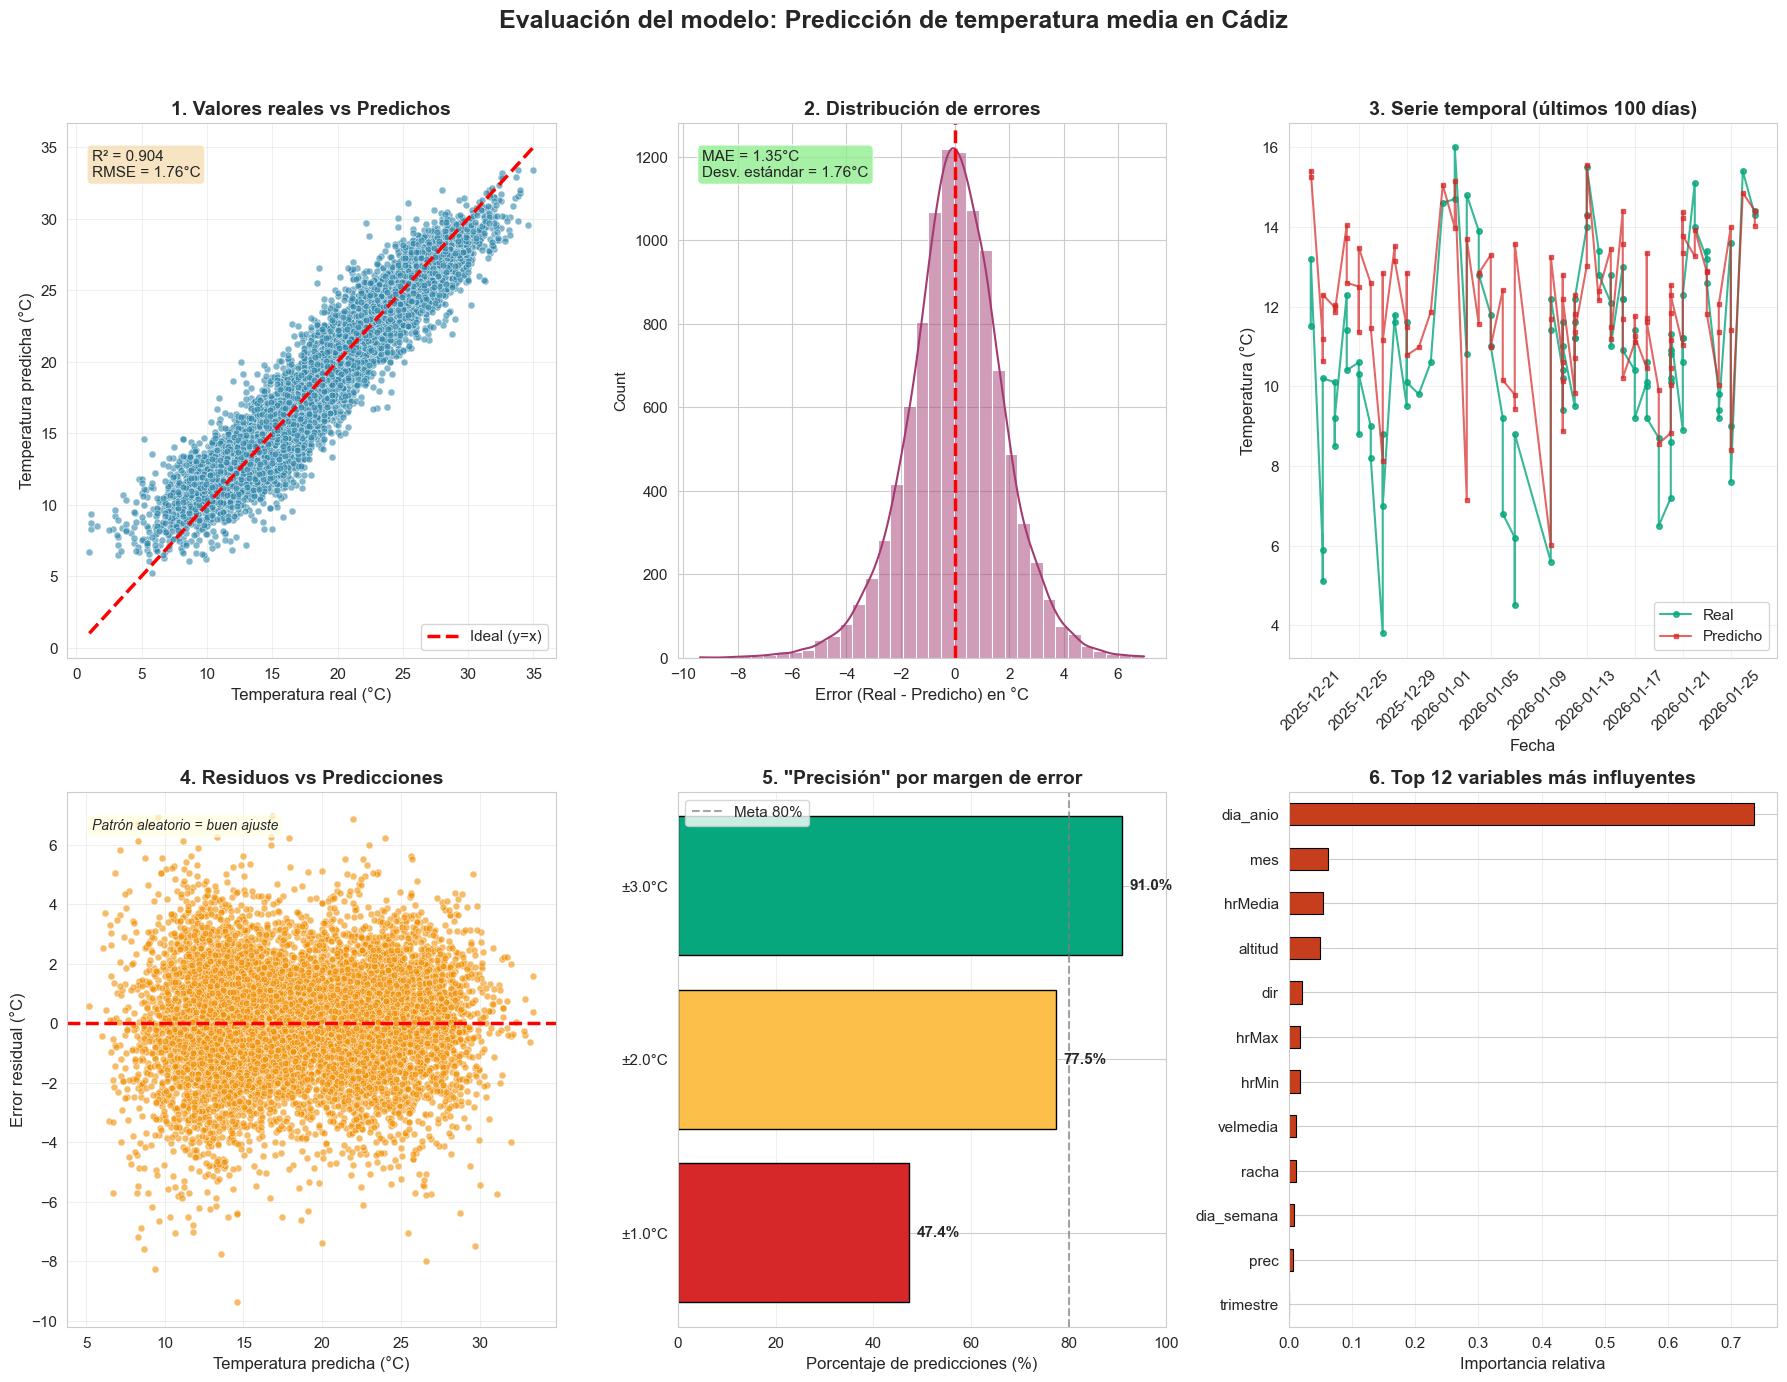


RESUMEN EJECUTIVO
• El modelo explica el 90.4% de la variabilidad de la temperatura media (R²=0.904)
• Error típico de predicción: 1.76°C (RMSE)
• 77.5% de las predicciones están dentro de ±2.0°C del valor real ← ¡Excelente para aplicaciones prácticas!

 Variables más influyentes:
   1. dia_anio (0.736)
   2. mes (0.062)
   3. hrMedia (0.054)
   4. altitud (0.050)
   5. dir (0.022)
Análisis completado exitosamente


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import json
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titleweight'] = 'bold'

print("="*70)
print("ANÁLISIS COMPLETO: PREDICCIÓN DE TEMPERATURA MEDIA EN CÁDIZ")
print("="*70)

try:
    df = pd.read_json('cadiz_final.json', encoding='utf-8')
    print("JSON cargado directamente como DataFrame")
except Exception as e1:
    try:
        with open('cadiz_final.json', 'r', encoding='utf-8') as f:
            data = json.load(f)
        if isinstance(data, list):
            df = pd.DataFrame(data)
            print("JSON convertido desde lista de registros")
        else:
            df = pd.json_normalize(data)
            print("JSON anidado normalizado")
    except Exception as e2:
        raise Exception(f"Error al cargar JSON: {e2}")

columnas_requeridas = ['fecha', 'tmed', 'altitud', 'prec', 'hrMedia']
faltantes = [c for c in columnas_requeridas if c not in df.columns]
if faltantes:
    raise ValueError(f"Columnas faltantes: {faltantes}. Columnas disponibles: {list(df.columns)}")

print(f"Datos cargados: {len(df)} registros | {len(df.columns)} columnas")
print(f"   Columnas principales: {', '.join(df.columns[:5])}...")

df_original = df.copy()  

df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df = df.dropna(subset=['fecha', 'tmed'])  

df['mes'] = df['fecha'].dt.month
df['dia_anio'] = df['fecha'].dt.dayofyear
df['dia_semana'] = df['fecha'].dt.dayofweek
df['trimestre'] = (df['mes'] - 1) // 3 + 1  

df = df.drop(columns=['indicativo', 'nombre', 'tmin', 'tmax'], errors='ignore')

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

imputer_num = SimpleImputer(strategy='median')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

if 'provincia' in cat_cols:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df[['provincia']] = imputer_cat.fit_transform(df[['provincia']])
    df = pd.get_dummies(df, columns=['provincia'], drop_first=True)


y = df['tmed']
X = df.drop(columns=['tmed', 'fecha'])  

fechas_completas = df['fecha'].reset_index(drop=True)
indices_train, indices_test = train_test_split(
    np.arange(len(X)), 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

X_train, X_test = X.iloc[indices_train], X.iloc[indices_test]
y_train, y_test = y.iloc[indices_train], y.iloc[indices_test]
fechas_test = fechas_completas.iloc[indices_test].reset_index(drop=True)

print(f"\n División de datos:")
print(f"   • Entrenamiento: {len(X_train)} muestras ({len(X_train)/len(df)*100:.1f}%)")
print(f"   • Prueba:        {len(X_test)} muestras ({len(X_test)/len(df)*100:.1f}%)")

print("\n Entrenando modelo Random Forest...")
modelo = RandomForestRegressor(
    n_estimators=150,
    max_depth=25,
    min_samples_split=8,
    random_state=42,
    n_jobs=-1
)
modelo.fit(X_train, y_train)


y_pred = modelo.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

dentro_1c = np.mean(np.abs(y_test - y_pred) <= 1.0) * 100
dentro_2c = np.mean(np.abs(y_test - y_pred) <= 2.0) * 100
dentro_3c = np.mean(np.abs(y_test - y_pred) <= 3.0) * 100

print("\n" + "="*70)
print(" MÉTRICAS DE DESEMPEÑO (conjunto de prueba)")
print("="*70)
print(f"   R² (coeficiente de determinación) : {r2:.4f}  → Explica el {r2*100:.1f}% de la variabilidad")
print(f"   RMSE (error típico)               : {rmse:.2f} °C")
print(f"   MAE (error absoluto medio)        : {mae:.2f} °C")
print(f"   MAPE (error porcentual medio)     : {mape:.1f}%")
print(f"\n   Precisión práctica (margen de error):")
print(f"      • Dentro de ±1.0°C : {dentro_1c:.1f}% de las predicciones")
print(f"      • Dentro de ±2.0°C : {dentro_2c:.1f}% de las predicciones ← ¡MUY BUENO!")
print(f"      • Dentro de ±3.0°C : {dentro_3c:.1f}% de las predicciones")
print("="*70)

fig = plt.figure(figsize=(18, 14))

ax1 = plt.subplot(2, 3, 1)
ax1.scatter(y_test, y_pred, alpha=0.6, s=25, color='#2E86AB', edgecolors='white', linewidth=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2.5, label='Ideal (y=x)')
ax1.set_xlabel('Temperatura real (°C)', fontsize=12)
ax1.set_ylabel('Temperatura predicha (°C)', fontsize=12)
ax1.set_title('1. Valores reales vs Predichos', fontsize=14)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.text(0.05, 0.95, f'R² = {r2:.3f}\nRMSE = {rmse:.2f}°C', 
         transform=ax1.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax2 = plt.subplot(2, 3, 2)
residuos = y_test - y_pred
sns.histplot(residuos, bins=35, kde=True, color='#A23B72', ax=ax2)
ax2.axvline(0, color='red', linestyle='--', lw=2.5)
ax2.set_xlabel('Error (Real - Predicho) en °C', fontsize=12)
ax2.set_title('2. Distribución de errores', fontsize=14)
ax2.text(0.05, 0.95, f'MAE = {mae:.2f}°C\nDesv. estándar = {residuos.std():.2f}°C', 
         transform=ax2.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

ax3 = plt.subplot(2, 3, 3)

df_temp = pd.DataFrame({
    'fecha': fechas_test,
    'real': y_test.values,
    'pred': y_pred
}).sort_values('fecha').tail(100)  

ax3.plot(df_temp['fecha'], df_temp['real'], 'o-', color='#06A77D', 
         label='Real', markersize=4, alpha=0.8, linewidth=1.5)
ax3.plot(df_temp['fecha'], df_temp['pred'], 's-', color='#D62828', 
         label='Predicho', markersize=3, alpha=0.7, linewidth=1.5)
ax3.set_xlabel('Fecha', fontsize=12)
ax3.set_ylabel('Temperatura (°C)', fontsize=12)
ax3.set_title('3. Serie temporal (últimos 100 días)', fontsize=14)
ax3.legend()
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

ax4 = plt.subplot(2, 3, 4)
ax4.scatter(y_pred, residuos, alpha=0.6, s=25, color='#F18F01', edgecolors='white', linewidth=0.5)
ax4.axhline(0, color='red', linestyle='--', lw=2.5)
ax4.set_xlabel('Temperatura predicha (°C)', fontsize=12)
ax4.set_ylabel('Error residual (°C)', fontsize=12)
ax4.set_title('4. Residuos vs Predicciones', fontsize=14)
ax4.grid(True, alpha=0.3)
ax4.text(0.05, 0.95, 'Patrón aleatorio = buen ajuste', 
         transform=ax4.transAxes, fontsize=10, style='italic',
         verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

ax5 = plt.subplot(2, 3, 5)
margenes = [1.0, 2.0, 3.0]
precisiones = [dentro_1c, dentro_2c, dentro_3c]
colores = ['#D62828' if p < 70 else '#FCBF49' if p < 85 else '#06A77D' for p in precisiones]

bars = ax5.barh([f'±{m}°C' for m in margenes], precisiones, color=colores, edgecolor='black')
ax5.set_xlabel('Porcentaje de predicciones (%)', fontsize=12)
ax5.set_title('5. "Precisión" por margen de error', fontsize=14)
ax5.set_xlim(0, 100)
ax5.grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, precisiones)):
    ax5.text(val + 1.5, i, f'{val:.1f}%', va='center', fontsize=11, fontweight='bold')

ax5.axvline(80, color='gray', linestyle='--', alpha=0.7, label='Meta 80%')
ax5.legend()

ax6 = plt.subplot(2, 3, 6)
importancias = pd.Series(modelo.feature_importances_, index=X.columns).sort_values(ascending=True)
top12 = importancias.tail(12)
top12.plot(kind='barh', color='#C73E1D', edgecolor='black', linewidth=0.8, ax=ax6)
ax6.set_xlabel('Importancia relativa', fontsize=12)
ax6.set_title('6. Top 12 variables más influyentes', fontsize=14)
ax6.grid(axis='x', alpha=0.3)

etiquetas = []
for label in top12.index:
    if 'provincia_' in label:
        etiquetas.append(label.replace('provincia_', 'Prov. ')[:20])
    else:
        etiquetas.append(label[:20])
ax6.set_yticklabels(etiquetas)


plt.suptitle('Evaluación del modelo: Predicción de temperatura media en Cádiz', 
             fontsize=18, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0.01, 1, 0.97])
plt.savefig('evaluacion_modelo_cadiz.png', dpi=300, bbox_inches='tight', facecolor='white')
print("\n Gráficas guardadas como 'evaluacion_modelo_cadiz.png'")

plt.show()


print("\n" + "="*70)
print("RESUMEN EJECUTIVO")
print("="*70)
print(f"• El modelo explica el {r2*100:.1f}% de la variabilidad de la temperatura media (R²={r2:.3f})")
print(f"• Error típico de predicción: {rmse:.2f}°C (RMSE)")
print(f"• {dentro_2c:.1f}% de las predicciones están dentro de ±2.0°C del valor real ← ¡Excelente para aplicaciones prácticas!")
print(f"\n Variables más influyentes:")
for i, (var, imp) in enumerate(importancias.sort_values(ascending=False).head(5).items(), 1):
    print(f"   {i}. {var.replace('provincia_', 'Prov. ')} ({imp:.3f})")
print("="*70)
print("Análisis completado exitosamente")
print("="*70)